#Creating the Input target pairs
so what essentially is an input target pair The model outputs a probability distribution over the vocabulary. The target token is compared to the predicted distribution using a loss function like cross-entropy. The model updates its weights to minimize this loss over millions or billions of such pairs.

So, we have to make that masked out layer
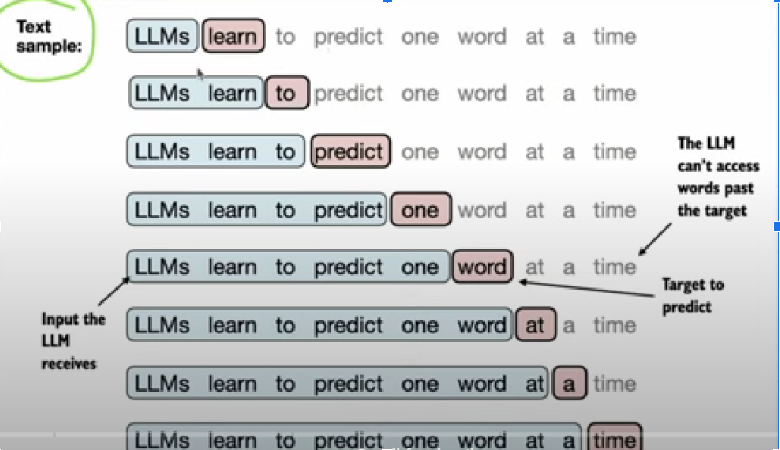

In [ ]:
import re
import requests

In [ ]:
url = "https://raw.githubusercontent.com/Satvik-jain/DeepLearning_LSTM_WordPredictor/refs/heads/main/The%20Verdict%20-%20Next%20Word%20Predictor/data/Data.txt"
r = requests.get(url)
book = r.text

In [ ]:
len(book)

20482

In [ ]:
#now we encode the toext using tiktoken
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
enc_text = tokenizer.encode(book)

In [ ]:
print(len(enc_text))
print(enc_text[:20])

5147
[40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438]


In [ ]:
# enc_text = enc_text[50:]

One of the easiest and most intuitive ways to create the input-target pairs for the nextword prediction task is to create two variables, x and y, where x contains the input tokens and y contains the targets, which are the inputs shifted by 1:
The context size determines how many tokens are included in the input

In [ ]:
context_size = 4 #this implies that the input sequence which will fed at once to the model will of length 4, and then the model will have to predict the next

#next you'll see that we'll define a word stride which how much the the sliding windoew moves forward to get the next input sequence and it's output
#for now thw stride is 1
x = enc_text[:context_size]
y = enc_text[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [40, 367, 2885, 1464]
y:      [367, 2885, 1464, 1807]


In [ ]:
for i in range(1,context_size):
  context = enc_text[:i]
  desired = enc_text[i]
  print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

I ---->  H
I H ----> AD
I HAD ---->  always


In [ ]:
#btw as you see this is the way of tokenization that has been implemented in tiktoken, let's replace enc_text with smoehting intersiting
enc_text = enc_text[50:]

In [ ]:
x = enc_text[:context_size]
y = enc_text[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


In [ ]:
for i in range(1,context_size+4):
  context = enc_text[:i]
  desired = enc_text[i]
  print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a
 and established himself in a ---->  vill
 and established himself in a vill ----> a
 and established himself in a villa ---->  on


#Now let's implement the DataLoader and Dataset
#####So what is a dataloader and dataset? these are a predefined pytorch classes which help us to properly organise our data and then use it feed to the ai model in abatch wise facility. It fecthes the input-target pairs in a sliding window approach
This appraoch decousples how you define data and then iterate over the loops for training efficiently

Step 1: Tokenize the entire text

Step 2: Use a sliding window to chunk the book into overlapping sequences of max_length

Step 3: Return the total number of rows in the dataset

Step 4: Return a single row from the dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):

  def __init__(self,text,tokenizer,max_length,stride):
    self.input_ids = []
    self.target_ids = []
    token_ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

    #sliding window approach
    for i in range(0,len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i+max_length]
      target_chunk = token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

The following code will use the GPTDatasetV1 to load the inputs in batches via a PyTorch DataLoader:

Step 1: Initialize the tokenizer

Step 2: Create dataset

Step 3: drop_last=True drops the last batch if it is shorter than the specified batch_size to prevent loss spikes during training

Step 4: num qorkers =  The number of CPU processes to use for preprocessing

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True,num_workers=0):
  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
  )

  return dataloader

In [ ]:
dataloader = create_dataloader_v1(book, batch_size=4, max_length=4, stride=2, shuffle=False
)

# data_iter = iter(dataloader)
# first_batch = next(data_iter)
# print(first_batch)


In [ ]:
for batch_idx, (inputs, targets) in enumerate(dataloader):
    if batch_idx >= 2: # Print first 3 batches
          print("\n(Stopped after 3 batches for demonstration purposes)")
          break
    print(f"\nBatch {batch_idx + 1}:")
    print(f"  Inputs (shape: {inputs.shape}):")
    print(inputs)
    print(f"  Targets (shape: {targets.shape}):")
    print(targets)


Batch 1:
  Inputs (shape: torch.Size([4, 4])):
tensor([[   40,   367,  2885,  1464],
        [ 2885,  1464,  1807,  3619],
        [ 1807,  3619,   402,   271],
        [  402,   271, 10899,  2138]])
  Targets (shape: torch.Size([4, 4])):
tensor([[  367,  2885,  1464,  1807],
        [ 1464,  1807,  3619,   402],
        [ 3619,   402,   271, 10899],
        [  271, 10899,  2138,   257]])

Batch 2:
  Inputs (shape: torch.Size([4, 4])):
tensor([[10899,  2138,   257,  7026],
        [  257,  7026, 15632,   438],
        [15632,   438,  2016,   257],
        [ 2016,   257,   922,  5891]])
  Targets (shape: torch.Size([4, 4])):
tensor([[ 2138,   257,  7026, 15632],
        [ 7026, 15632,   438,  2016],
        [  438,  2016,   257,   922],
        [  257,   922,  5891,  1576]])

(Stopped after 3 batches for demonstration purposes)


In [ ]:
#you can play around with batch size, stride etc. to see how the input to the model is looking like and analyse further